12:53:55 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Evaluation Metrics:
MAE  = 59.73
RMSE = 64.81
MAPE = 882.07%


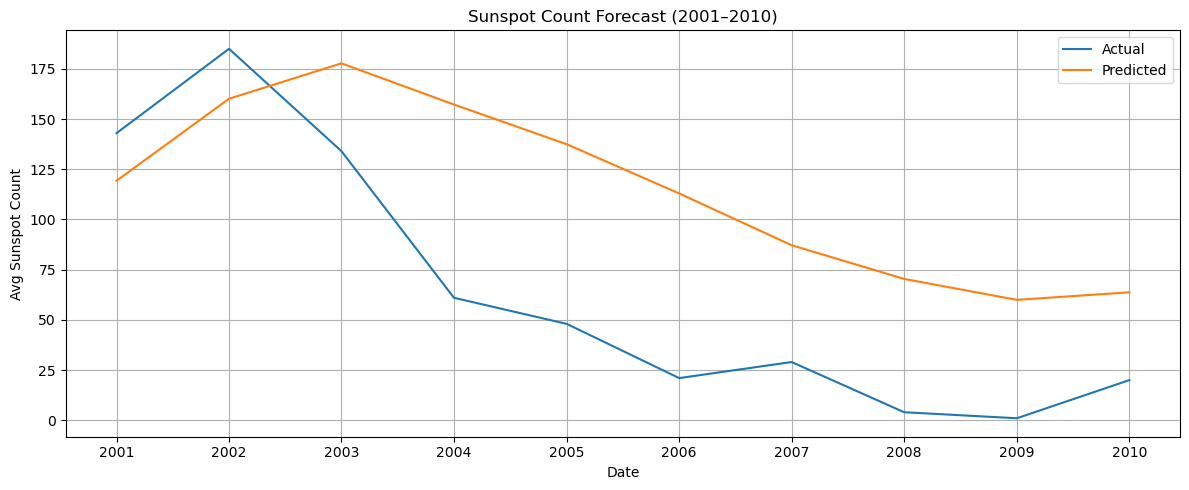


📁 Forecast saved to 'sunspot_forecast_test_output3.csv'


In [1]:
# STEP 1: Install Prophet if not already
# pip install prophet

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# STEP 2: Load and preprocess training data
train_df = pd.read_csv("train.csv")
train_df['Month'] = pd.to_datetime(train_df['Month'], format='%d-%m-%Y')
train_df = train_df.rename(columns={'Month': 'ds', 'Avg_sunspot_count': 'y'})

# Optional: Apply log transform to stabilize variance (uncomment if needed)
# train_df['y'] = np.log1p(train_df['y'])

# STEP 3: Split into training and testing for evaluation (2001–2010)
train = train_df[train_df['ds'] < '2001-01-01']
test = train_df[(train_df['ds'] >= '2001-01-01') & (train_df['ds'] <= '2010-12-01')]

# STEP 4: Train Prophet with custom seasonality
model = Prophet(yearly_seasonality=False)
model.add_seasonality(name='11-year-cycle', period=11 * 365.25, fourier_order=15)
model.fit(train)

# STEP 5: Forecast next 120 months for evaluation
future = model.make_future_dataframe(periods=120, freq='MS')
forecast = model.predict(future)

# STEP 6: Evaluation
forecast_test = forecast[(forecast['ds'] >= '2001-01-01') & (forecast['ds'] <= '2010-12-01')]
merged = forecast_test[['ds', 'yhat']].merge(test, on='ds')

# If log transform was used, revert back
# merged['yhat'] = np.expm1(merged['yhat'])

# Evaluation metrics
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100

print(f"✅ Evaluation Metrics:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(merged['ds'], merged['y'], label='Actual')
plt.plot(merged['ds'], merged['yhat'], label='Predicted')
plt.title('Sunspot Count Forecast (2001–2010)')
plt.xlabel('Date')
plt.ylabel('Avg Sunspot Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 7: Load your test.csv (future dates) and predict
test_dates = pd.read_csv("test.csv")
test_dates['ds'] = pd.to_datetime(test_dates['Month'], format='%d-%m-%Y')

# Predict for given dates
future_pred = model.predict(test_dates[['ds']])

# If log transform used, revert here too
# future_pred['yhat'] = np.expm1(future_pred['yhat'])

# Save results
output_df = future_pred[['ds', 'yhat']].rename(columns={'ds': 'Month', 'yhat': 'Avg_sunspot_count'})
output_df.to_csv("sunspot_forecast_test_output3.csv", index=False)

print("\n📁 Forecast saved to 'sunspot_forecast_test_output3.csv'")
